In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import LSODA, solve_ivp
from scipy.special import jv, jve, iv, i1
from numpy.linalg import solve, inv
import numba
import sys


sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

$$Ω\propto r^{-3/2}$$

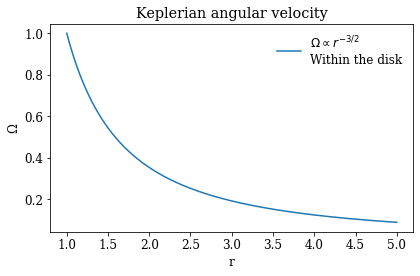

In [65]:
r = np.linspace(1, 5, 1000)

fig, axs = plt.subplots(figsize = (6,4))
axs.set(title='Keplerian angular velocity', xlabel='r', ylabel='Ω')
axs.plot(r, r**(-3/2), label='$Ω\propto r^{-3/2}$\nWithin the disk')

axs.legend(frameon = False)
plt.tight_layout()

$$\frac{\partial\Sigma}{\partial t}  
= \frac{3}{r} \frac{\partial}{\partial r}
\left[r^{1/2} \frac{\partial}{\partial r}(\nu\Sigma r^{1/2})\right] 
$$
$$X \equiv 2r^{1/2}, \quad f \equiv \frac{3}{2}\Sigma X$$

$$\Rightarrow \frac{\partial f}{\partial t}=\frac{12\nu}{X^2}\frac{\partial^2f}{\partial X^2}$$

### *Initial condition for Green's solution*
$$\Sigma(r,t=0)=\frac{m}{2\pi r_0}\delta(r-r_0)$$

In [66]:
N = 2001
x_i = 0
x_f = 2
x = np.linspace(x_i, x_f, N)
Δx = x[1] - x[0]
Δt = 0.004

D = A_matrix(4, 2, N) / Δx**2

### Setting the 1. derivative in both ends to 0:
$$\Rightarrow \frac{\partial f}{\partial t} = 0$$

In [67]:
A = np.identity(N) - D * Δt


A[0] = 0
A[0, :5] = forward_backward(5, 1, forward = True)[0]
A[-1] = 0
A[-1, -5:] = forward_backward(5, 1, forward = False)[0]

In [68]:
A_ = inv(A)

t = np.arange(0, 0.256 + Δt, Δt)
sol = []
b = np.zeros_like(x)
b[x == 1] = 5
b_initial = b.copy()
for _ in t:
    b[0] = 0
    b[-1] = 0
    sol.append(A_ @ b)
    b = A_ @ b 
sol = np.asarray(sol)

In [69]:
b_initial

array([0., 0., 0., ..., 0., 0., 0.])

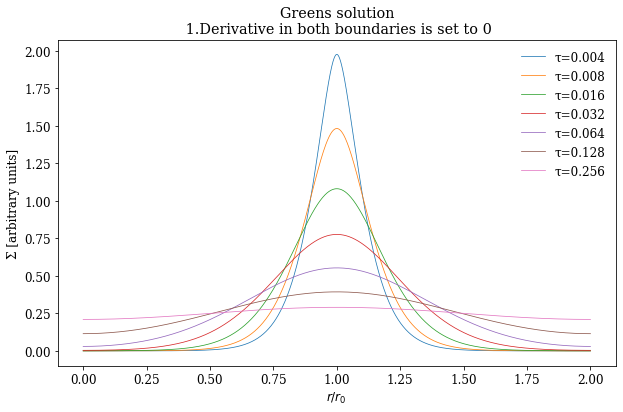

In [70]:
fig, axs = plt.subplots(figsize=(10,6)) 

for τ in [0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]:
    axs.plot(x, 100*sol[t == τ][0], label=f'τ={τ}', lw=0.75)
#for i in range(0, 10):
#    axs.plot(x, sol[i], label=f'τ={t[i]:1.2e}')

#axs.plot(x, b_initial, label='Initial condition')
axs.set(title='Greens solution\n 1.Derivative in both boundaries is set to 0', ylabel='Σ [arbitrary units]', xlabel='$r/r_0$')
plt.legend(frameon=False)

#### Setting 1. derivative at $r=0$ to 0 and $Σ(r\rightarrow\inf)=0$

In [71]:
A = np.identity(N) - D * Δt


A[0] = 0
A[0, :5] = forward_backward(5, 1, forward = True)[0]
A[-1] = 0
A[-1, -1:] = 1

In [72]:
A_ = inv(A)

t = np.arange(0, 0.256 + Δt, Δt)
sol = []
b = np.zeros_like(x)
b[x == 1] = 5
b_initial = b.copy()
for _ in t:
    b[0] = 0
    b[-1] = 0
    sol.append(A_ @ b)
    b = A_ @ b 
sol = np.asarray(sol)

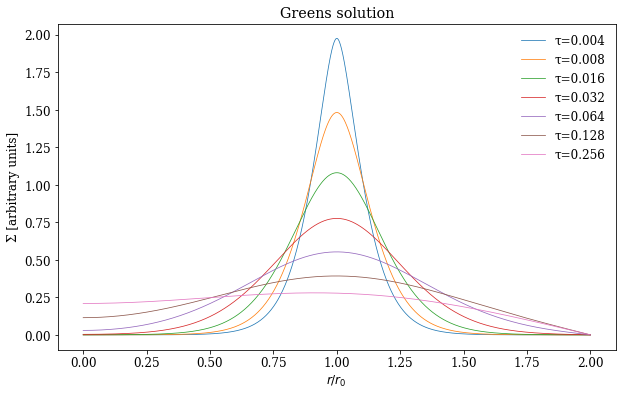

In [73]:
fig, axs = plt.subplots(figsize=(10,6)) 

for τ in [0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]:
    axs.plot(x, 100*sol[t == τ][0], label=f'τ={τ}', lw=0.75)
#for i in range(0, 10):
#    axs.plot(x, sol[i], label=f'τ={t[i]:1.2e}')

#axs.plot(x, b_initial, label='Initial condition')
axs.set(title='Greens solution', ylabel='Σ [arbitrary units]', xlabel='$r/r_0$')
plt.legend(frameon=False)

#### Trying to solve for Green's solution with solve_ivp

$$\frac{\partial^2f}{\partial X^2}\approx\frac{f_{i+1}-2f_i+f_{i-1}}{\Delta x^2}$$

In [74]:
#@numba.njit
def diffusion(T, t, D, N, L, Tl, Tr):

    #  Calculate spacing between points
    delta = float(L) / float(N)

    @numba.njit
    def equations(t, T):
        #  Boundary conditions set explicitly.  This is probably redundant
        #  as these numbers are set before the function is called and the
        #  code takes the time derivative at these points to be zero, but
        #  we'll ensure the proper boundary conditions anyway.
        T[0] = Tl
        T[-1] = Tr

        #  Initialize time derivative vector
        Tprime = np.zeros( (N) )

        #  We are being lazy and forcing the temperature of the boundaries
        #  not to change by setting the derivative to zero at those points
        Tprime[0] = 0.0
        Tprime[-1] = 0.0

        #  Implement the diffusion equation in the interior points using the
        #  central difference formula.  This can be vectorized for better
        #  performance, but I am just using a loop here.
        for i in range(1, N - 1):
            Tprime[i] = D * (T[i+1] - 2 * T[i] + T[i-1]) / delta**2

        return Tprime

    #  Solve the equation by calling solve_ivp and return the solution
    sol = solve_ivp(equations, [tspan[0], tspan[-1]], T, t_eval = tspan)
    return sol

In [75]:
#  Divide the rod into N points, 100 in this case
N = 2001
L = 2           #  Rod length
D = 0.01        #  Diffusion coefficient
Tl = 0.         #  Left-hand boundary condition
Tr = 0       #  Right-hand boundary condition

tspan = np.linspace(0, 0.256, 65)

#  Initial conditions
T = b_initial

#  These are the boundary conditions.
T[0] = Tl
T[-1] = Tr

#  Solve the problem by calling our function which invokes the solver
sol  = diffusion(T, tspan, D, N, L, Tl, Tr)

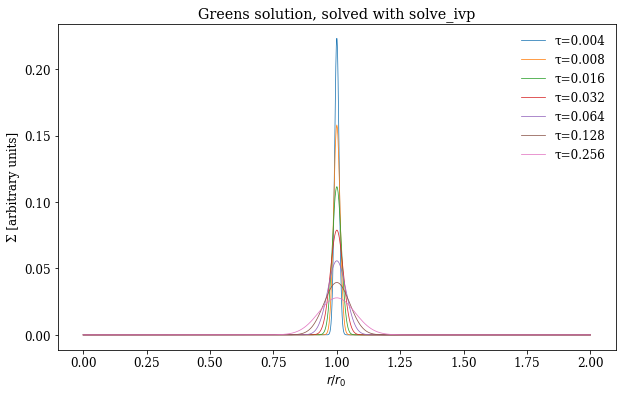

In [76]:
fig, axs = plt.subplots(figsize=(10,6)) 

for τ in [0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]:
    axs.plot(x, sol.y[:, sol.t == τ], label=f'τ={τ}', lw=0.75)

axs.set(title='Greens solution, solved with solve_ivp', ylabel='Σ [arbitrary units]', xlabel='$r/r_0$')
plt.legend(frameon=False)

#### Trying to solve for Green's solution with LSODA, setting the second derivative of f, $\frac{\partial^2f}{\partial X^2}=0$ in the boundaries

#### First time including the $D = \frac{12\nu}{X^2}\approx\frac{1}{X^2}$ 

In [77]:
Ν = N
Δx = Δx
def time_diff(t, f):
    fprime = np.zeros(N)
    fprime[0] = 0.0
    fprime[-1] = 0.0

    fprime[1 : -1] = x[1 : -1]**(-2) * (f[:-2] - 2 * f[1: -1] + f[2:]) / Δx**2

    return fprime    

In [78]:
tspan = np.linspace(0, 0.032, 9)
sol = solve_ivp(time_diff, [tspan[0], tspan[-1]], b_initial, t_eval = tspan, method = 'LSODA')

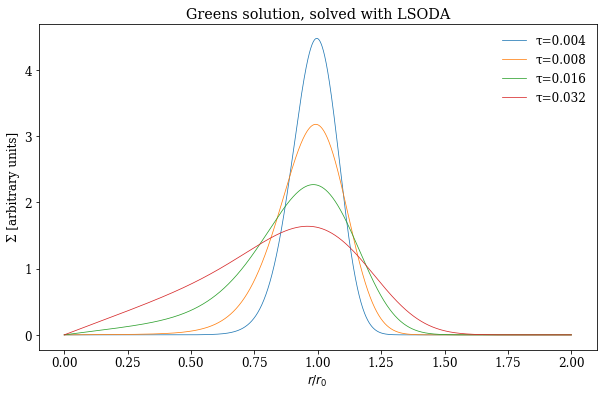

In [79]:
fig, axs = plt.subplots(figsize=(10,6)) 

for τ in [0.004, 0.008, 0.016, 0.032]:
    axs.plot(x, 200 * sol.y[:, sol.t == τ], label=f'τ={τ}', lw=0.75)

axs.set(title='Greens solution, solved with LSODA', ylabel='Σ [arbitrary units]', xlabel='$r/r_0$')
plt.legend(frameon=False)

### Defining and testing analytical solution, eqs. 3.21

In [107]:
def analytic_green(x, τ):
    return (np.pi * τ)**(-1) * x**(-1/4) * np.exp(- (1 + x**2) / τ) * i1(2*x / τ)
    
# https://docs.scipy.org/doc/scipy/reference/special.html
# Different kinds of bessel functions were tried - "Modified Bessel function of order 1." is the working one
# (Not including pi in the first part of the soultion gives the same scale on the y-axis as Armitage)

In [110]:
N = 2001
x_i = 0.15
x_f = 2.1
x = np.linspace(x_i, x_f, N)
Δx = x[1] - x[0]
Δt = 0.004

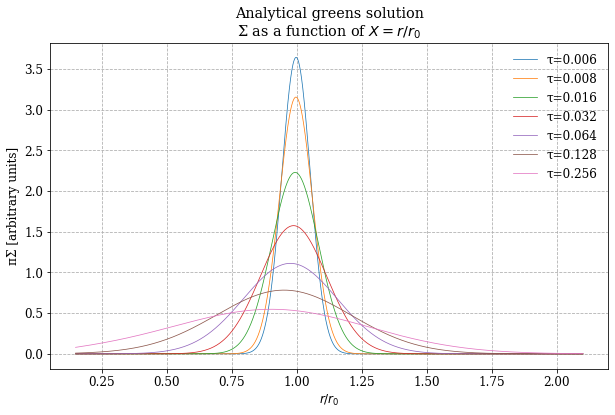

In [114]:
fig, axs = plt.subplots(figsize=(10,6)) 
plt.grid(ls='--')
times = [0.006, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]
for τ in times:
    axs.plot(r, np.pi * analytic_green(r, τ), label=f'τ={τ}', lw=0.75)

axs.set(title='Analytical greens solution\nΣ as a function of $X=r/r_0$', ylabel='πΣ [arbitrary units]', xlabel='$r/r_0$')
plt.legend(frameon=False)

### Change analytical solution to f

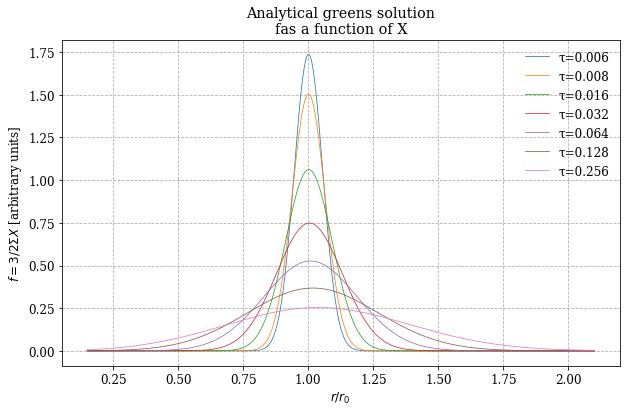

In [118]:
fig, axs = plt.subplots(figsize=(10,6)) 
times = [0.006, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]
plt.grid(ls='--')
for τ in times:
    axs.plot(x, analytic_green(x, τ) * x * 3/2, label=f'τ={τ}', lw=0.75)

axs.set(title='Analytical greens solution\nfas a function of X', ylabel='$f=3/2 \Sigma X$ [arbitrary units]', xlabel='$r/r_0$')
plt.legend(frameon=False)

#### Trying to solve for Green's solution with LSODA, setting the first derivative of f, $\frac{\partial f}{\partial X}=0$ in the boundaries

In [84]:
anal_inital = analytic_green(x, 0.006)

In [85]:
@numba.njit
def time_diff(t, f):
    f_x1 = np.zeros(N)
    f_x2 = np.zeros(N)
   
   #Estimating 1. deriavative with Central finite difference scheme
    f_x1[1 : -1] = (-0.5 * f[:-2] + 0.5 * f[2:]) / Δx


    #Estimating 2. deriavative from 1. derivative
    f_x2[1 : -1] = (-0.5 * f_x1[:-2] + 0.5 * f_x1[2:]) / Δx

    f_x2[0] = (-3/2*f_x1[0] + 2 * f_x1[1] + 1/2 * f_x1[2]) / Δx

    f_x2[-1] = (1/2*f_x1[-3] - 2 * f_x1[-2] + 3/2 * f_x1[-1]) / Δx
    
    return x**(-2) * f_x2   

In [86]:
sol = solve_ivp(time_diff, [times[1], times[-1]], y0 = anal_inital, t_eval = times[1:], method = 'LSODA')

Underneath the solution of f is obtained for $f=\frac{3}{2}\Sigma X$ where $X=2r^{1/2}$. Trying to get the plot  $\Sigma(r)$ i.e. dividing by X gives to big data and the plot is not possible.

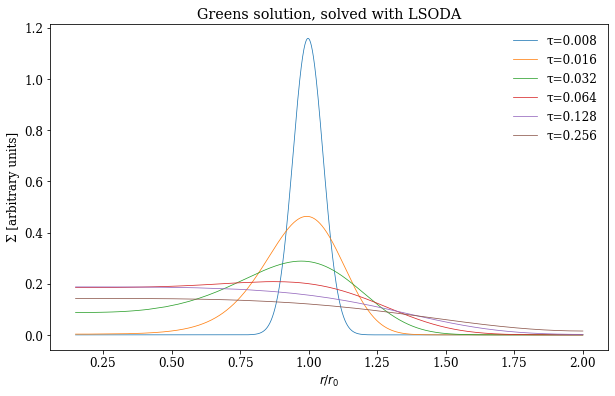

In [87]:
fig, axs = plt.subplots(figsize=(10,6)) 

for τ in times[1:]:
    axs.plot(x, sol.y[:, sol.t == τ], label=f'τ={τ}', lw=0.75)

axs.set(title='Greens solution, solved with LSODA', ylabel='Σ [arbitrary units]', xlabel='$r/r_0$')
plt.legend(frameon=False, loc = 'upper right')

In [89]:
def time_diff(t, f):
    fprime = np.zeros(N)
    fprime[0] = 0.0
    fprime[-1] = 0.0

    fprime[1 : -1] = x[1 : -1]**(-2) * (f[:-2] - 2 * f[1: -1] + f[2:]) / Δx**2

    return fprime    

In [90]:
sol = solve_ivp(time_diff, [times[1], times[-1]], y0 = anal_inital, t_eval = times[1:], method = 'LSODA')

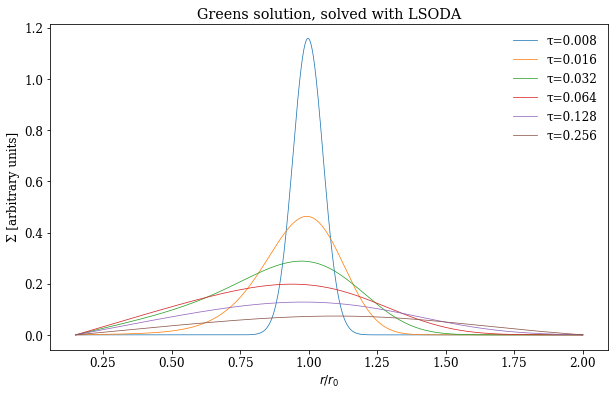

In [91]:
fig, axs = plt.subplots(figsize=(10,6)) 

for τ in times[1:]:
    axs.plot(x, sol.y[:, sol.t == τ], label=f'τ={τ}', lw=0.75)

axs.set(title='Greens solution, solved with LSODA', ylabel='Σ [arbitrary units]', xlabel='$r/r_0$')
plt.legend(frameon=False, loc = 'upper right')

# Boundary conditions
### Suzuki and possibly Lynden-Bell:
$$\frac{\partial}{\partial r}\left(\Sigma r^{3/2}\right) = 0$$
*(Which corresponds to zero-torque boundary conditions)*

See Lynden - Bell p. 611 middle

### Armitage:
$$\frac{d\Omega}{dr} = 0$$
*(Viscouss stress vanishes)*
#### Or (is this the same as)?:
$$\frac{\partial f}{\partial r} = \frac{\partial }{\partial r} \left(3\Sigma r^{1/2}\right) = 0$$


#### Okay, okay, okay Never has one seen so many almost solutions that resemble Green's actual solution. But alas I'll now try again but with the physical constants and solve for $\Sigma$ and $r$ initially!